### 1) Simple FM regression

In [1]:
from pyfm import pylibfm
from sklearn.feature_extraction import DictVectorizer
import numpy as np


# Training data

training_data = [
    {"user": "1", "item": "5", "age": 19},
    {"user": "2", "item": "43", "age": 33},
    {"user": "3", "item": "20", "age": 55},
    {"user": "4", "item": "10", "age": 20},
]

id2group = np.array([0, 1, 1, 1, 1, 2, 2, 2, 2])

dictionary_vectorizer = DictVectorizer()
one_hot_sparse_matrix = dictionary_vectorizer.fit_transform(training_data)

one_hot_array = one_hot_sparse_matrix.toarray()


# Labels

training_data_size = one_hot_sparse_matrix.shape[0]

labels = np.array([float(sample_id % 2) for sample_id in range(training_data_size)])


# Printouts

print("training_data:", training_data)
print("id2group:", id2group)
print("one_hot_array:", one_hot_array)
print("labels:", labels)

training_data: [{'user': '1', 'item': '5', 'age': 19}, {'user': '2', 'item': '43', 'age': 33}, {'user': '3', 'item': '20', 'age': 55}, {'user': '4', 'item': '10', 'age': 20}]
id2group: [0 1 1 1 1 2 2 2 2]
one_hot_array: [[19.  0.  0.  0.  1.  1.  0.  0.  0.]
 [33.  0.  0.  1.  0.  0.  1.  0.  0.]
 [55.  0.  1.  0.  0.  0.  0.  1.  0.]
 [20.  1.  0.  0.  0.  0.  0.  0.  1.]]
labels: [0. 1. 0. 1.]


In [2]:
# Model

factors_count = np.max(one_hot_sparse_matrix.indices) + 1

fm = pylibfm.FM(num_cols=factors_count, 
                id2group=id2group,
                algorithm="sgda")

# Training

EPOCHS_COUNT = 15

for epoch in range(EPOCHS_COUNT):
    
    fm.learn(one_hot_sparse_matrix, labels)
    
    evaluation_result = fm.evaluate(one_hot_sparse_matrix, labels)
    
    print(f"Epoch: {epoch}, evaluation result: {evaluation_result:.4f}")
    

# Prediction    
    
test_data = [{"user": "1", "item": "5", "age": 19}, {"user": "4", "item": "10", "age": 20}]

one_hot_test_data = dictionary_vectorizer.transform(test_data)

prediction = fm.predict(one_hot_test_data)

print("Prediction:", prediction)

Epoch: 0, evaluation result: 0.5000
Epoch: 1, evaluation result: 0.5000
Epoch: 2, evaluation result: 0.5000
Epoch: 3, evaluation result: 0.5000
Epoch: 4, evaluation result: 0.5000
Epoch: 5, evaluation result: 0.2462
Epoch: 6, evaluation result: 0.2462
Epoch: 7, evaluation result: 0.3155
Epoch: 8, evaluation result: 0.5000
Epoch: 9, evaluation result: 0.0646
Epoch: 10, evaluation result: 0.0000
Epoch: 11, evaluation result: 0.0000
Epoch: 12, evaluation result: 0.0000
Epoch: 13, evaluation result: 0.0000
Epoch: 14, evaluation result: 0.0000
Prediction: [0. 1.]


### 2) Full-Scale FM Regression

In [3]:
### Data

# https://grouplens.org/datasets/movielens/100k/

# https://files.grouplens.org/datasets/movielens/ml-100k.zip

In [4]:
import time
import numpy as np

import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from pyfm import pylibfm


ML_100K_PATH = "./ml-100k/"
MOVIE_TRAIN_FILENAME = "ua.base"
MOVIE_TEST_FILENAME = "ua.test"

STOCK_DATA_PATH = "./simulated_prices/"
STOCK_DATA_FILENAME = "option_prices_small.xlsx"

In [5]:
def load_movie_data(filename, path=ML_100K_PATH):
    
    x = []
    ratings = []
    
    with open(path + filename) as f:
        for line in f:
            
            user_id, movie_id, rating, timestamp = line.split('\t')
            
            x.append({"user_id": user_id, "movie_id": movie_id})
            ratings.append(float(rating))
        
    ratings = np.array(ratings)

    return x, ratings

In [6]:
def load_stock_data(filename, path=STOCK_DATA_PATH):
    
    # Filter
    
    x_column_names = [
        'initial_stock_price', 
        'strike_price', 
        'time_to_maturity',
        'risk_free_interest_rate',
        'dividend_rate',
        'volatility',
        'time_steps_count',
        'paths_count'
    ]
    
    y_column_name = 'simulated_price'
    
    # Modify
    
    stock_data = pd.read_excel(path + filename)
    
    stock_data['volatility'] = stock_data['volatility'] * 10

    stock_data['initial_stock_price'] = stock_data['initial_stock_price'].astype(int) // 100
    stock_data['simulated_price'] = stock_data['simulated_price'].astype(int) // 100
    
    train, test = train_test_split(stock_data, test_size=0.1)
    
    # X

    x_train_df = train[x_column_names]
    x_test_df = test[x_column_names]
    
    x_train_df = x_train_df.astype(int)
    x_test_df = x_test_df.astype(int)
    
    x_train_df = x_train_df.astype(str)
    x_test_df = x_test_df.astype(str)
    
    x_train = x_train_df.to_dict('records')
    x_test = x_test_df.to_dict('records')
    
    # Y

    y_train_df = train[y_column_name]
    y_test_df = test[y_column_name] 

    y_train = y_train_df.to_numpy()
    y_test = y_test_df.to_numpy()
    
    return x_train, x_test, y_train, y_test

In [7]:
# Dataloaders

def get_stock_data():

    stock_x_train, stock_x_test, stock_y_train, stock_y_test = load_stock_data(STOCK_DATA_FILENAME)

    print("Stock train data:", len(stock_x_train))
    print("Stock test data:", len(stock_x_test))
    
    return stock_x_train, stock_x_test, stock_y_train, stock_y_test


def get_movie_data():
    
    movie_x_train, movie_y_train = load_movie_data(MOVIE_TRAIN_FILENAME)
    movie_x_test, movie_y_test = load_movie_data(MOVIE_TEST_FILENAME)

    print("Movie train data:", len(movie_x_train))
    print("Movie test data:", len(movie_x_test))
    
    return movie_x_train, movie_x_test, movie_y_train, movie_y_test

In [8]:
# x_train, x_test, y_train, y_test = get_movie_data()

x_train, x_test, y_train, y_test = get_stock_data()

Stock train data: 9000
Stock test data: 1000


In [9]:
x_train[:2], y_train[:2]

([{'initial_stock_price': '77',
   'strike_price': '1000',
   'time_to_maturity': '1',
   'risk_free_interest_rate': '0',
   'dividend_rate': '0',
   'volatility': '2',
   'time_steps_count': '1',
   'paths_count': '10'},
  {'initial_stock_price': '82',
   'strike_price': '1000',
   'time_to_maturity': '1',
   'risk_free_interest_rate': '0',
   'dividend_rate': '0',
   'volatility': '2',
   'time_steps_count': '1',
   'paths_count': '10'}],
 array([68, 66]))

In [10]:
# Data preparation

dictionary_vectorizer = DictVectorizer()

x_train_sparse = dictionary_vectorizer.fit_transform(x_train)
x_test_sparse = dictionary_vectorizer.transform(x_test)

x_train_sparse_array = x_train_sparse.toarray()

x_train_sparse_array.shape

(9000, 107)

In [11]:
# FM Model

LEARNING_RATE = 0.001
FACTORS_COUNT = 8
TASK_TYPE = "regression"

columns_count = np.max(x_train_sparse.indices) + 1

fm = pylibfm.FM(num_cols=columns_count, 
                num_factor=FACTORS_COUNT, 
                task=TASK_TYPE, 
                learning_rate=LEARNING_RATE)

columns_count

107

In [12]:
# Training

EPOCHS_COUNT = 50


train_mean_squared_errors = []
test_mean_squared_errors = []

total_start_time = time.time()


for epoch in range(EPOCHS_COUNT):
    
    # Learn
    
    learn_start_time = time.time()
    
    fm.learn(x_train_sparse, y_train)
    
    learn_time = time.time() - learn_start_time
    
    
    # Predict
    
    predict_start_time = time.time()
    
    preds_train = fm.predict(x_train_sparse)
    preds_test = fm.predict(x_test_sparse)

    predict_time = time.time() - predict_start_time
    
    
    # Evaluate
    
    train_mean_squared_error = mean_squared_error(y_train, preds_train)
    test_mean_squared_error = mean_squared_error(y_test, preds_test)
    
    # train_evaluation_result = fm.evaluate(X_train, y_train)        
    # test_evaluation_result = fm.evaluate(X_test, y_test)
    
    train_mean_squared_errors.append(train_mean_squared_error)
    test_mean_squared_errors.append(test_mean_squared_error)
    
    
    # Printout
    
    if not epoch % 10:
    
        print(f"Epoch: {epoch + 1}/{EPOCHS_COUNT}",      
              f"Train MSE: {train_mean_squared_error:.4f}",
              f"Test MSE: {test_mean_squared_error:.4f}",
              f"Learn time: {learn_time:.2f}",
              f"Predict time: {predict_time:.2f}",)

total_time = time.time() - total_start_time

print(f"Total time: {total_time:.2f} seconds")

Epoch: 1/50 Train MSE: 252.8562 Test MSE: 236.3388 Learn time: 0.02 Predict time: 0.02
Epoch: 11/50 Train MSE: 229.4760 Test MSE: 214.9739 Learn time: 0.02 Predict time: 0.02
Epoch: 21/50 Train MSE: 169.2314 Test MSE: 159.1688 Learn time: 0.02 Predict time: 0.02
Epoch: 31/50 Train MSE: 133.5745 Test MSE: 126.0215 Learn time: 0.02 Predict time: 0.02
Epoch: 41/50 Train MSE: 109.6755 Test MSE: 104.0877 Learn time: 0.02 Predict time: 0.02
Total time: 1.85 seconds


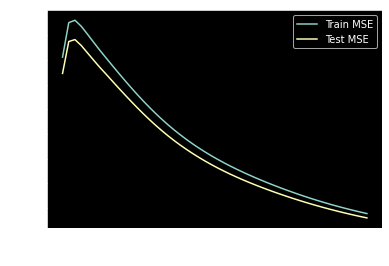

In [13]:
from matplotlib import pyplot as plt

plt.style.use('dark_background')

plt.plot(train_mean_squared_errors, label="Train MSE")
plt.plot(test_mean_squared_errors, label="Test MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")

plt.legend();

### 3) SVM Regression

In [138]:
from sklearn import svm

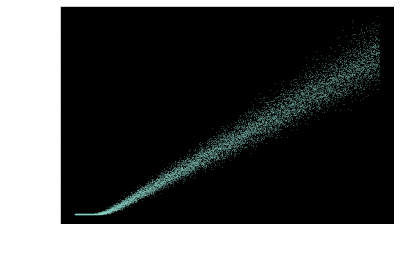

In [139]:
# Input data

stock_data = pd.read_excel(STOCK_DATA_PATH + STOCK_DATA_FILENAME)

initial_stock_prices = stock_data['initial_stock_price'].to_numpy().reshape(-1, 1)
option_prices = stock_data['simulated_price'].to_numpy()

plt.scatter(initial_stock_prices, option_prices, s=0.01)
plt.xlabel("Initial stock price")
plt.ylabel("Option price");

In [43]:
# SVR

option_prices_regressor = svm.SVR(kernel="poly", degree=2)

In [44]:
# Fit

option_prices_regressor.fit(initial_stock_prices, option_prices)

SVR(degree=2, kernel='poly')

In [45]:
# Predict

predicted_option_prices = option_prices_regressor.predict(initial_stock_prices)

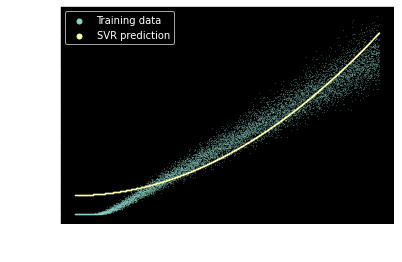

In [127]:
# Plot

plt.scatter(initial_stock_prices, option_prices, s=0.01, label="Training data")
plt.scatter(initial_stock_prices, predicted_option_prices, s=0.01, label="SVR prediction")
plt.xlabel("Initial stock price")
plt.ylabel("Option price")
plt.legend(markerscale=50)
plt.show()

In [20]:
# Multiple Degrees

SVR_POLYNOMIAL_DEGREES = np.arange(1, 7)

In [21]:
option_prices_regressors = {degree: svm.SVR(kernel="poly", degree=degree)
                            for degree in SVR_POLYNOMIAL_DEGREES}

option_prices_regressors

{1: SVR(degree=1, kernel='poly'),
 2: SVR(degree=2, kernel='poly'),
 3: SVR(kernel='poly'),
 4: SVR(degree=4, kernel='poly'),
 5: SVR(degree=5, kernel='poly'),
 6: SVR(degree=6, kernel='poly')}

SVR polynomial degree 1 - 3.19 seconds
SVR polynomial degree 2 - 3.89 seconds
SVR polynomial degree 3 - 3.81 seconds
SVR polynomial degree 4 - 4.86 seconds
SVR polynomial degree 5 - 5.84 seconds
SVR polynomial degree 6 - 12.49 seconds


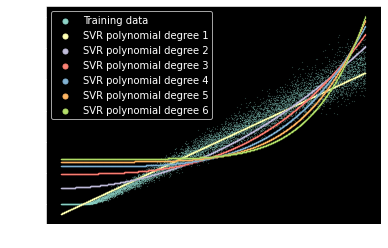

In [22]:
figure, ax = plt.subplots()

ax.scatter(initial_stock_prices, option_prices, s=0.01, label="Training data")

for degree, option_prices_regressor in option_prices_regressors.items():
    
    start_time = time.time()
    
    option_prices_regressor.fit(initial_stock_prices, option_prices)
    
    predicted_option_prices = option_prices_regressor.predict(initial_stock_prices)
    
    estimated_time = time.time() - start_time
    
    label = f"SVR polynomial degree {degree}"

    line = ax.scatter(initial_stock_prices, predicted_option_prices, s=0.01, label=label)
    
    print(f"{label} - {estimated_time:.2f} seconds")

    
plt.xlabel("Initial stock price")
plt.ylabel("Option price")

plt.legend(markerscale=50)   
plt.show()

### 4) SVR Training

In [135]:
# Load input data

stock_data = pd.read_excel(STOCK_DATA_PATH + STOCK_DATA_FILENAME)

train, test = train_test_split(stock_data, test_size=0.1)

x_columns = ['initial_stock_price', 'volatility']

x_train = train[x_columns].to_numpy().reshape(-1, len(x_columns))
x_test = test[x_columns].to_numpy().reshape(-1, len(x_columns))

y_train = train['simulated_price'].to_numpy()
y_test = test['simulated_price'].to_numpy()

x_train.shape, x_test.shape

((9000, 2), (1000, 2))

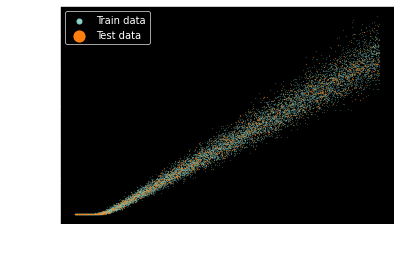

In [136]:
# Plot input data

plt.scatter(x_train[:, 0], y_train, s=0.01, label="Train data")
plt.scatter(x_test[:, 0], y_test, s=0.05, color='tab:orange', label="Test data")

plt.xlabel("Initial stock price")
plt.ylabel("Option price")

plt.legend(markerscale=50)
plt.show()

In [137]:
# SVR training

EPOCHS_COUNT = 10

option_prices_regressor = svm.SVR(kernel="poly", degree=2)


train_mean_squared_errors = []
test_mean_squared_errors = []

total_start_time = time.time()


for epoch in range(EPOCHS_COUNT):
    
    # Learn
    
    learn_start_time = time.time()
    
    option_prices_regressor.fit(x_train, y_train)
    
    learn_time = time.time() - learn_start_time
    
    
    # Predict
    
    predict_start_time = time.time()
    
    predictions_train = option_prices_regressor.predict(x_train)
    predictions_test = option_prices_regressor.predict(x_test)

    predict_time = time.time() - predict_start_time
    
    
    # Evaluate
    
    train_mean_squared_error = mean_squared_error(y_train, predictions_train)
    test_mean_squared_error = mean_squared_error(y_test, predictions_test)
    
    train_mean_squared_errors.append(train_mean_squared_error)
    test_mean_squared_errors.append(test_mean_squared_error)
    
    
    # Printout
    
    if not epoch % 1:
    
        print(f"Epoch: {epoch + 1}/{EPOCHS_COUNT}",      
              f"Train MSE: {train_mean_squared_error:.4f}",
              f"Test MSE: {test_mean_squared_error:.4f}",
              f"Learn time: {learn_time:.2f}",
              f"Predict time: {predict_time:.2f}",)

total_time = time.time() - total_start_time

print(f"Total time: {total_time:.2f} seconds")

Epoch: 1/10 Train MSE: 608629.6245 Test MSE: 617362.8631 Learn time: 2.23 Predict time: 1.00
Epoch: 2/10 Train MSE: 608629.6245 Test MSE: 617362.8631 Learn time: 2.12 Predict time: 1.00
Epoch: 3/10 Train MSE: 608629.6245 Test MSE: 617362.8631 Learn time: 2.12 Predict time: 1.04
Epoch: 4/10 Train MSE: 608629.6245 Test MSE: 617362.8631 Learn time: 2.26 Predict time: 1.06
Epoch: 5/10 Train MSE: 608629.6245 Test MSE: 617362.8631 Learn time: 2.23 Predict time: 1.01
Epoch: 6/10 Train MSE: 608629.6245 Test MSE: 617362.8631 Learn time: 2.14 Predict time: 1.01
Epoch: 7/10 Train MSE: 608629.6245 Test MSE: 617362.8631 Learn time: 2.13 Predict time: 1.00
Epoch: 8/10 Train MSE: 608629.6245 Test MSE: 617362.8631 Learn time: 2.12 Predict time: 0.99
Epoch: 9/10 Train MSE: 608629.6245 Test MSE: 617362.8631 Learn time: 2.15 Predict time: 1.00
Epoch: 10/10 Train MSE: 608629.6245 Test MSE: 617362.8631 Learn time: 2.20 Predict time: 1.01
Total time: 31.82 seconds


### 5) SVM with RBF kernel

In [25]:
# https://scikit-learn.org/stable/auto_examples/svm/plot_svm_nonlinear.html#sphx-glr-auto-examples-svm-plot-svm-nonlinear-py

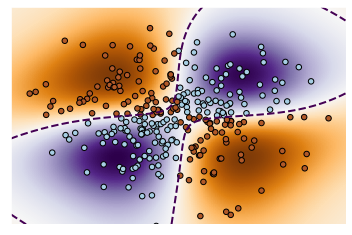

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 500))
np.random.seed(0)
X = np.random.randn(300, 2)
Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

# fit the model
clf = svm.NuSVC(gamma="auto")
clf.fit(X, Y)

# plot the decision function for each datapoint on the grid
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect="auto",
    origin="lower",
    cmap=plt.cm.PuOr_r,
)
contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linestyles="dashed")
plt.scatter(X[:, 0], X[:, 1], s=30, c=Y, cmap=plt.cm.Paired, edgecolors="k")
plt.xticks(())
plt.yticks(())
plt.axis([-3, 3, -3, 3])
plt.show()